<a href="https://colab.research.google.com/github/adaptive-learning/adaptive-programming-research/blob/master/analysis/performance/input_data_correlation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Input Data Correlations

*How much do various input data considered for performance measures correlate with each other? Is it important to take all of them into account when measuing the performance, or can we safely use only a subset of them?*

In this analysis, we explore the relationships between simple, aggregated features of task sessions:
- number of edits,
- number of executions,
- number of "thinkings" (defined below), 
- total solving time.


### Thinking Actions

Motivaton behind the number of thinkings is to express the extra time the student needed to think (not just to drag and drop blocks), discretized crudely enough to neglect differences caused by individual speeds and different devices. If the gap between two successive actions is greater than 5 seconds, we assume a thinking between them. If the gap was very long, then we  assume multiple thinkings, but the threshold for each next thinking grows exponentially and is capped at 5, i.e. it is $min(5, \lfloor log_5(t) \rfloor)$.

For example, consider the following time series of click-based actions (E = edit, X = execution):

```
(12s) E (2s) E (3s) E (1s) X (6s) E (30s) E (1s) X
```

We would replace the time deltas by thinking actions as follows (T = thinking):

```
T E E E X T E T T E X
```


Then we simply count the total number of thinkings. However, the distribution of total thinking actions is highly skewed (see below), so we will later work with log-transformed counts (the same holds for edits, executions, and time).

## Imports and helpers

In [0]:
from collections import *
from functools import *
from itertools import *
from math import *
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from google.colab import widgets

sns.set()
sns.set_context('notebook', font_scale=2)

In [3]:
! git clone https://github.com/adaptive-learning/adaptive-programming-research.git

Cloning into 'adaptive-programming-research'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 18 (delta 2), reused 8 (delta 1), pack-reused 0
Unpacking objects: 100% (18/18), done.


In [0]:
# Utils.
# TODO: Hide them.
# TODO: Copy the useful ones to the research tools repo (+ docs and tests).

DATA_DIR = './adaptive-programming-research/data/robomission-2018-10-27/'

# TODO: Automatically decode json and list columns (see my/Papi's utils).
def load(name):
    path = DATA_DIR + name + '.csv'
    df = pd.read_csv(path, index_col='id')
    return df

## Data Preparation

In [5]:
tasks = load('tasks')
ts = load('task_sessions')
# Only consider sessions with an interaction.
ts = ts[ts.time_spent > 0]
# Set maximum spent time to 1h.
ts.time_spent = ts.time_spent.clip_upper(60 * 60)
print('Number of task session:', len(ts))

Number of task session: 57916


In [6]:
snapshots = load('program_snapshots')
edits = snapshots[snapshots.granularity == 'edit']
executions = snapshots[snapshots.granularity == 'execution']
print('Number of snapshots:', len(snapshots))
snapshots.head(2)

Number of snapshots: 967745


,task_session,time,program,granularity,order,correct,time_from_start,time_delta
id,,,,,,,,
9,3,2017-11-10T12:19:58.349785Z,f,edit,1,NaN,3,3
10,3,2017-11-10T12:20:00.225268Z,f,execution,1,True,4,4


In [25]:
# Data imputation.

# Number of edits and executions for each task session.
ts['edits'] = edits.groupby('task_session').program.count()
ts.edits = ts.edits.fillna(0)
ts['executions'] = executions.groupby('task_session').program.count()
ts.executions = ts.executions.fillna(0)



# Extra-thinking actions. Motivation here is to account for the time
# student spends on extra thinking without building the program,
# but make it crude enough to neglect differences cause by individual
# speeds and devices.
def time_to_thinking(time, time_per_thinking=5, cap=5):
    # If you think for more than 5 seconds -> 1 extra thinking.
    # If you think for more than 5^k seconds -> k extra-thinkings.
    # Maximum #thinkings is 5 and you need to think for nearly an hour to get this.
    return min(cap, floor(log(time, time_per_thinking)) if time > 0 else 0)

# Current logs don't include time delta from any last action
# (only from the action of the same granularity).
# TODO: Improve logs to include this attribute.
def to_delta(times):
    deltas = times.diff()
    deltas.iat[0] = times.iat[0]  # diff() puts NaN in the first row.
    return deltas

prev_action_delta = snapshots.groupby('task_session').time_from_start.transform(to_delta)
snapshots['thinkings'] = prev_action_delta.apply(time_to_thinking)
ts['thinkings'] = snapshots.groupby('task_session').thinkings.sum()

# Precompute log-transformed features.
ts['log_time'] = ts.time_spent.apply(np.log)
ts['log_edits'] = (ts.edits + 1).apply(np.log)
ts['log_executions'] = (ts.executions + 1).apply(np.log)
ts['log_thinkings'] = (ts.thinkings + 1).apply(np.log) # Not clear if it makes sense (this is already a sum of log-and-capped times).

ts = ts.join(tasks, on='task')

ts.head()

,student,task,solved,start,end,time_spent,edits,executions,thinkings,log_time,...,log_thinkings,name,setting,solution,section,level,level2,order,mission,problemset
id,,,,,,,,,,,,,,,,,,,,,
39,917,26,False,2017-11-13T10:58:19.666306Z,2017-11-13T10:59:21.969801Z,62,0.0,0.0,3,4.127134,...,1.386294,turning-right-and-left,{'fields': 'b|bM|b|bM|bA;k|kA|kA|k|kM;kA|kM|k|...,frl,1.2.3,1,2,3,commands,1012
28,584,41,True,2017-11-12T08:57:39.741460Z,2017-11-12T08:58:43.087657Z,63,6.0,1.0,7,4.143135,...,2.079442,yellow-hint,{'fields': 'b|b|b|b|b;k|k|k|kD|k;k|k|k|kD|k;k|...,Wy{r}W!b{f},4.2.2,4,2,2,while,1042
13,29,8,True,2017-11-10T12:24:07.602156Z,2017-11-10T12:24:24.986604Z,17,5.0,1.0,0,2.833213,...,0.000000,shooting,{'fields': 'bA|bA|bA|b|bA;kA|k|kA|kM|kA;kA|k|k...,rfssf,2.1.2,2,1,2,commands-2,1021
3,29,51,True,2017-11-10T12:19:55.337206Z,2017-11-10T12:20:00.215662Z,4,1.0,1.0,0,1.386294,...,0.000000,three-steps-forward,{'fields': 'b|b|b|b|b;k|k|k|k|k;k|k|k|k|k;k|k|...,fff,1.1.1,1,1,1,commands,1011
29,584,51,True,2017-11-12T08:58:45.905092Z,2017-11-12T08:59:22.765583Z,36,1.0,1.0,2,3.583519,...,1.098612,three-steps-forward,{'fields': 'b|b|b|b|b;k|k|k|k|k;k|k|k|k|k;k|k|...,fff,1.1.1,1,1,1,commands,1011


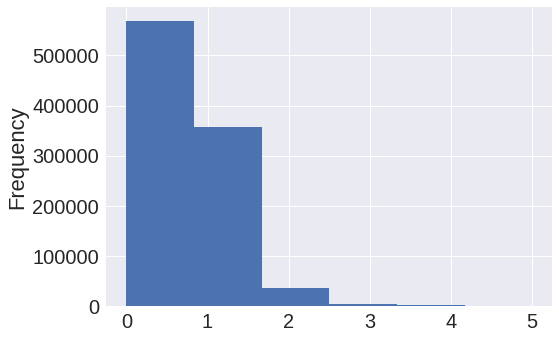

In [18]:
# Verify that thinkigs have a reasonable distribution
# (i.e., there are usually 0 or 1 between actions).
# TODO: Is there a more appropriate graph for this kind of data?
snapshots.thinkings.plot.hist(bins=6)

## Global Correlations

All considered input features (time, edits, executions, and thinkings) have significantly skewed distributions:

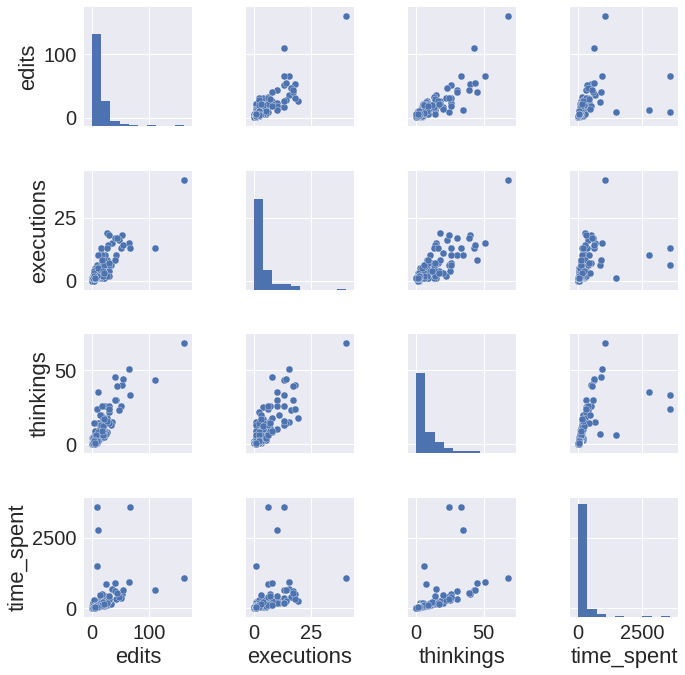

In [26]:
#@title Distributions and relationships between various input data (sample)
ts_sample = ts.sample(200)
g = sns.pairplot(ts_sample, vars=['edits', 'executions', 'thinkings', 'time_spent'])
#g.fig.suptitle('Original features');

Log-transformed features have more symetric distributions. We can see that they correlate with each other:

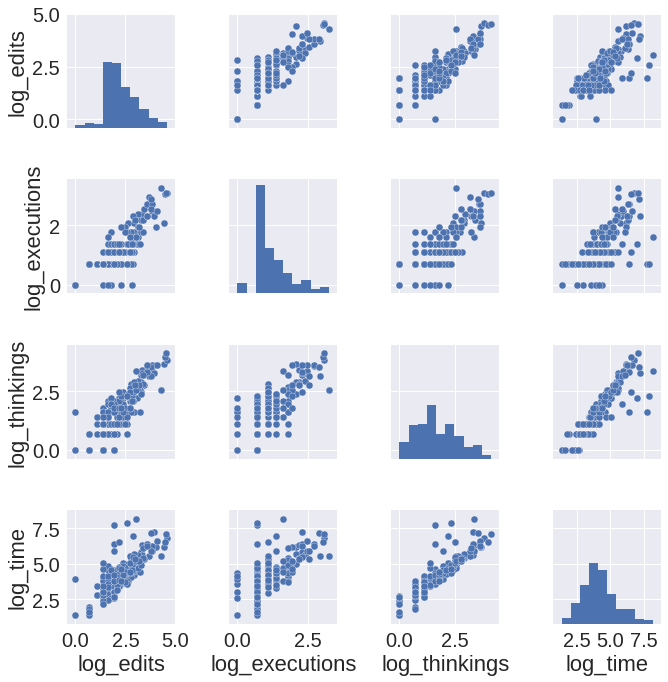

In [27]:
#@title Distributions and relationships between log-transformed input data (sample)
ts_sample = ts.sample(200)
LOG_FEATURES = ['log_edits', 'log_executions', 'log_thinkings', 'log_time']
g = sns.pairplot(ts_sample, vars=LOG_FEATURES)

---


**When aggregated across all tasks, various input data (such as log-edits and log-time) are highly correlated (except for the raw time before log-transformation).**

---





,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Correlations: original features


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

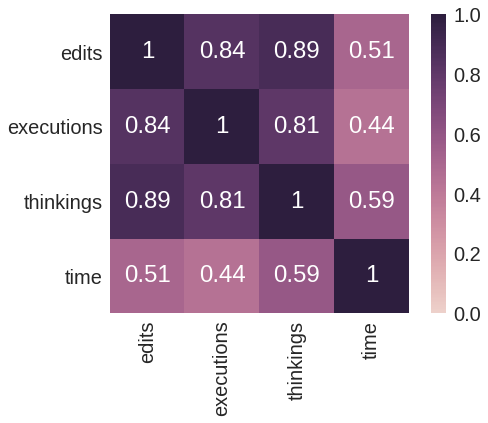

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Correlations: log-transformed features


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

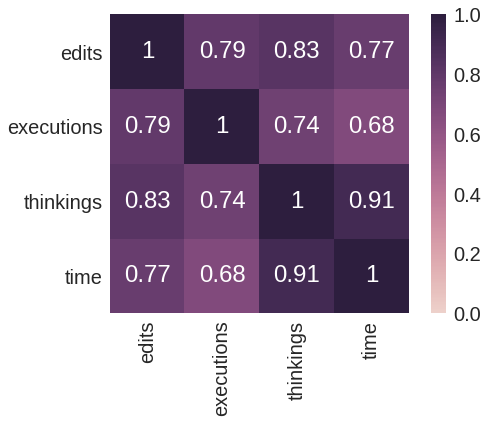

<IPython.core.display.Javascript object>

In [78]:
#@title Global correlations between various input data (left: original, right: log-transformed)
def show_corrs(corrs, save_as=None):
    cmap = sns.cubehelix_palette(as_cmap=True)
    ax = sns.heatmap(corrs, vmin=0, vmax=1, annot=True,
                     square=True, cmap=cmap)
    ax.set_xlabel('')
    ax.set_ylabel('')  


grid = widgets.Grid(2, 2, header_row=True)
with grid.output_to(0, 0):
    print('Correlations: original features')
with grid.output_to(1, 0):
    input_data = pd.DataFrame(OrderedDict(
        edits=ts.edits,
        executions=ts.executions,
        thinkings=ts.thinkings,
        time=ts.time_spent,
    ))
    corrs = input_data.corr()
    show_corrs(corrs)

with grid.output_to(0, 1):
    print('Correlations: log-transformed features')
with grid.output_to(1, 1):
    input_data = pd.DataFrame(OrderedDict(
        edits=ts.log_edits,
        executions=ts.log_executions,
        thinkings=ts.log_thinkings,
        time=ts.log_time,
    ))
    corrs = input_data.corr()
    show_corrs(corrs)

## Task Slices

High global correlations doesn't mean that correlations are high for all relevant slices of data. For example, there are some tasks for which the correlation between the number of edits and the solving time (log-transformed) is low. Let's look at an example of a task with the lowest correlation between edits and time:

Task: shot. Corr: 0.4193669541577504


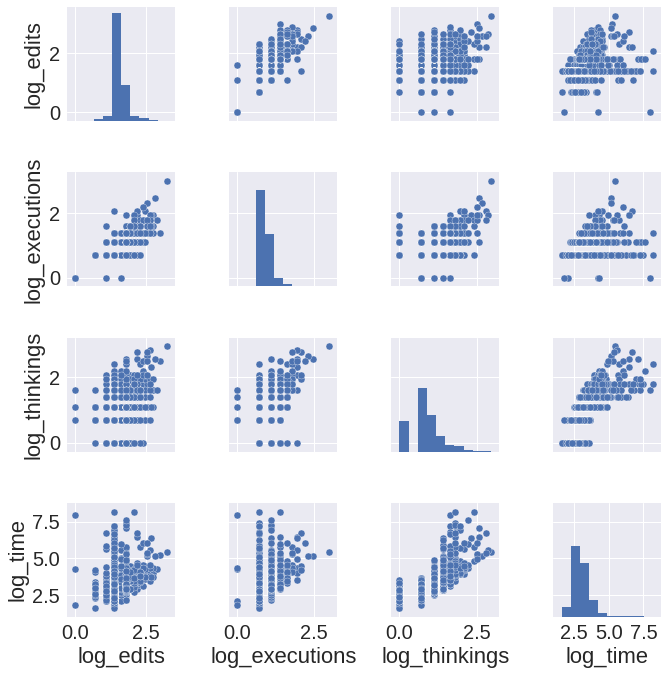

In [29]:
#@title Relationships between features for a specific task.
# Find the task with the lowest correlation.
tasks_corrs = ts.groupby('task').apply(lambda g: g.log_edits.corr(g.log_time))
tasks_corrs_sorted = tasks_corrs.sort_values()
task_id = tasks_corrs_sorted.index[0]
name = tasks.loc[task_id]['name']
corr = tasks_corrs.loc[task_id]
print(f'Task: {name}. Corr: {corr}')
g = sns.pairplot(ts[ts.task == task_id], vars=LOG_FEATURES)

Too see if it's a case for multiple tasks, not just a single one, let's compute correlations within each task slice. First, we filter tasks that have at least 100 task sessions. Then, for each pair of input data, and for each task, we compute the correlation between these pair of input data over all task sessions of this task. Finally, we plot histograms of computed correlations on a pair grid:

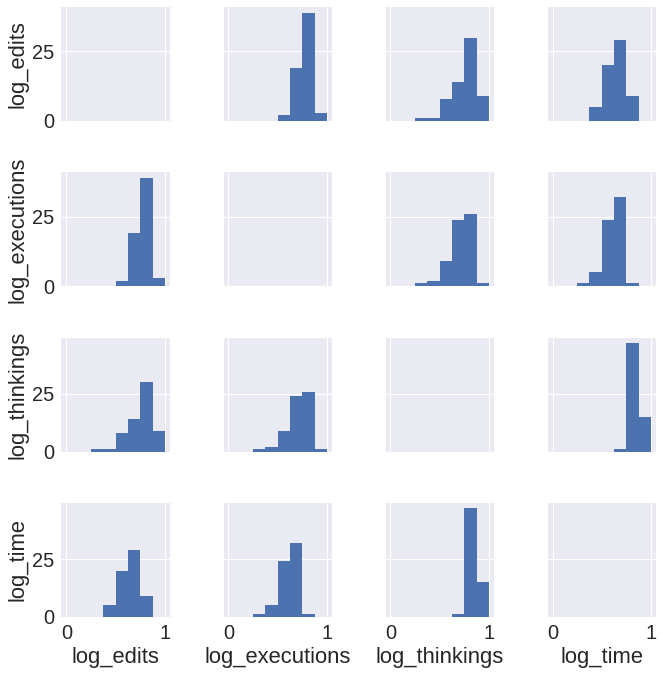

In [23]:
#@title Histograms of correlations within tasks.
# Only consider tasks with at least 100 task sessions (there are 63 of them).
# TODO: Find a more elegant way how to do that.
tasks_filtered = ts.groupby('task').task.count() >= 100
ts_filtered = ts.join(tasks_filtered.to_frame(name='filtered'), on='task').query('filtered')

def corr_per_task_hist(input1, input2, **kwargs):
    # TODO: Find a more elegant way.
    grouped = ts_filtered.assign(input1=input1, input2=input2).groupby('task')
    corrs = grouped.apply(lambda group: group.input1.corr(group.input2))
    plt.hist(corrs, bins=np.linspace(0, 1, 9), **kwargs)

g = sns.PairGrid(ts_filtered, vars=['log_edits', 'log_executions', 'log_thinkings', 'log_time'])
g.map_offdiag(corr_per_task_hist)

---

**There are some tasks for which the correlation between time-related vs click-related input data is not very strong. On the other hand, correlation between time and thinkigs is high for every task, and similarly between edits and executions.**

---

## Difficulty Slices (Problem Sets)

One particular consideration is that the global computation of the correlations is dominated by the tasks in a first few levels, because these have significantly more task sessions collected. Let's explore if the correlations are high independently of the difficulty of the task. We divide all tasks into 3 difficulty groups based on the level of the problem set they belong to: easy (L1 and L2), medium (L3 and L4) and difficult (L5 and above). Then we plot the relationship and compute correlations for each of the group.

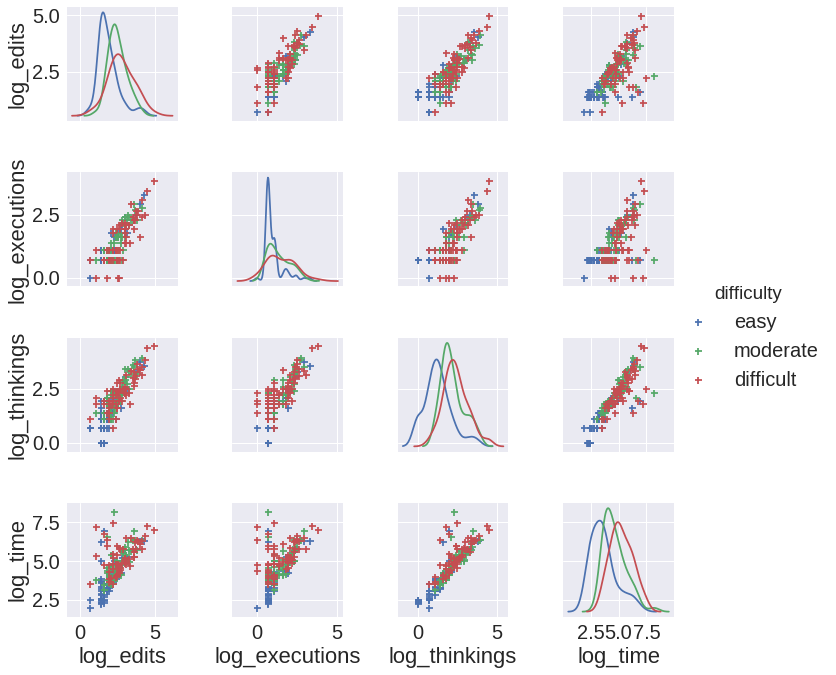

In [87]:
#@title Distributions and relationships sliced by difficulty (sample).

# Group tasks into 3 difficulty levels based on problem sets they belong to (reasonable proxy).
lvl_to_difficulty = lambda lvl: 'easy' if lvl in [1, 2] else 'moderate' if lvl in [3, 4] else 'difficult'
ts['difficulty'] = ts['level'].map(lvl_to_difficulty)
#sns.countplot(ts.difficulty)

# Create a stratified sample.
ts_sample = ts.groupby('difficulty').apply(lambda group: group.sample(n=60))
# And shuffle it (to improve visualization below; all difficult ts would be on top otherwise).
ts_sample = ts_sample.sample(frac=1)

# Plot the relationships.
g = sns.pairplot(
    ts_sample, vars=LOG_FEATURES, diag_kind='kde', markers='+',
    hue='difficulty', hue_order=['easy', 'moderate', 'difficult'])

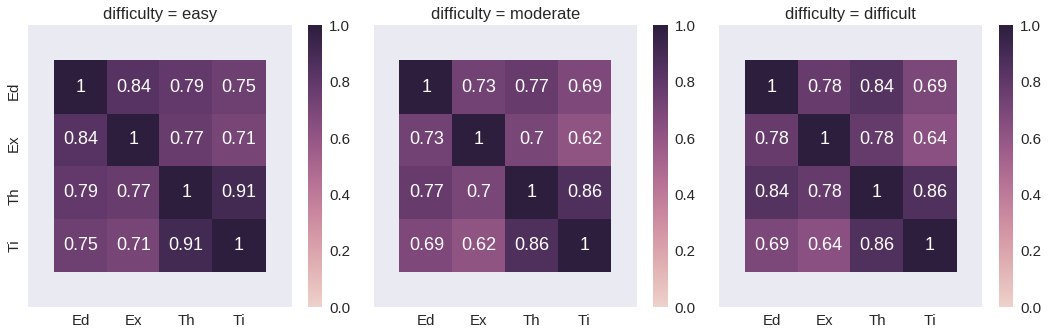

In [86]:
#@title Correlation matrices for difficulty slices.

def corr_plot(*args, **kwargs):
    input_data = kwargs['data'][LOG_FEATURES]
    input_data.columns = ['Ed', 'Ex', 'Th', 'Ti']
    corrs = input_data.corr()
    show_corrs(corrs)


with sns.plotting_context(context='notebook', font_scale=1.5):
    g = sns.FacetGrid(ts, col='difficulty', size=5)
    g.map_dataframe(corr_plot);

---

**
The correlations are largest for easy tasks, but they don't drop considerably with increasing difficulty.
**

---


TODO:
- Consider if there is a better type of graph to emphasize the change of the correlations with increasing difficulty (line plot).
- Try comparing more extreme groups (e.g. L1, L5, L9).
- Try slicing per phases (frist vs. third).

## Solution Length Slices

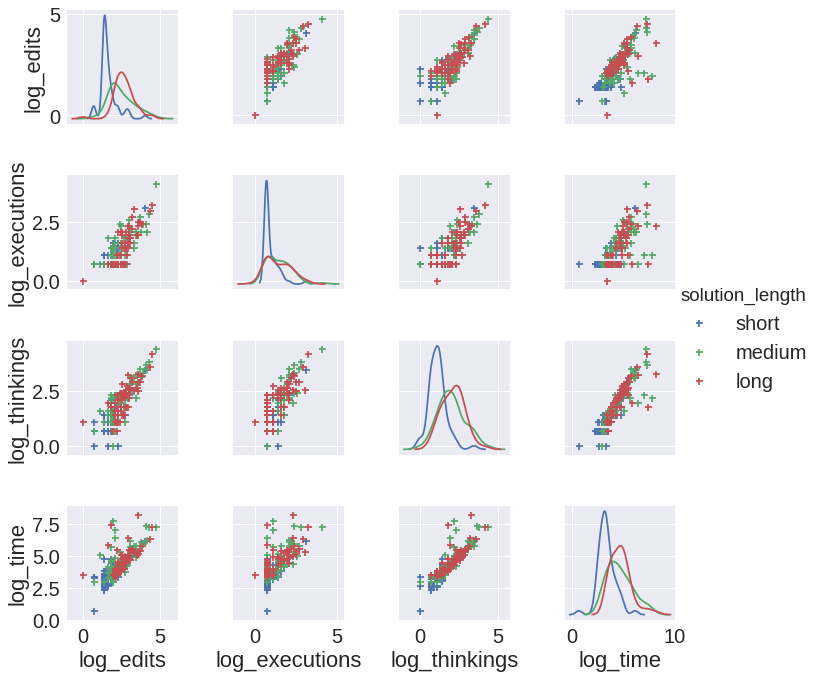

In [103]:
#@title Distributions and relationships sliced by solution length (sample).

# Group tasks into 3 groups based on the length of the sample solution.
length_levels = ['short', 'medium', 'long']
to_length_bin = lambda l: 'short' if l <= 5 else 'medium' if l <= 10 else 'long'
ts['solution_length'] = ts.solution.str.len().map(to_length_bin)
#sns.countplot(ts.solution_length)

# Create a stratified sample.
ts_sample = ts.groupby('solution_length').apply(lambda group: group.sample(n=60))
ts_sample = ts_sample.sample(frac=1)

# Plot the relationships.
g = sns.pairplot(
    ts_sample, vars=LOG_FEATURES, diag_kind='kde', markers='+',
    hue='solution_length', hue_order=length_levels)

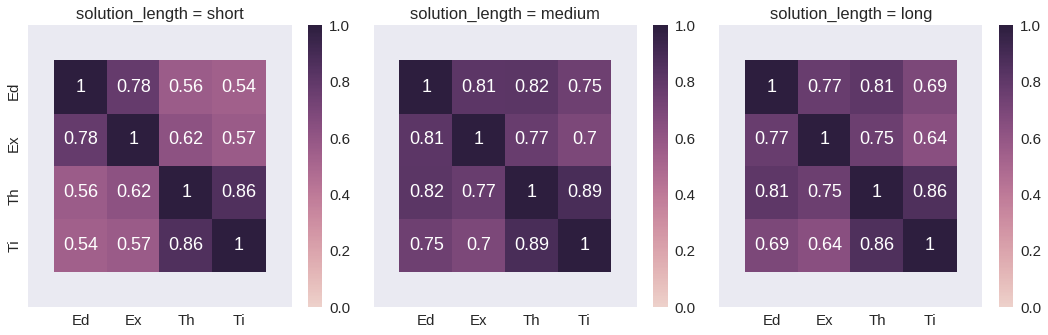

In [104]:
#@title Correlation matrices for solution length slices.

with sns.plotting_context(context='notebook', font_scale=1.5):
    g = sns.FacetGrid(ts, col='solution_length', col_order=length_levels, size=5)
    g.map_dataframe(corr_plot);

---

**
For tasks with a short solution, the correlation between click-based and time-based features is not high.
**

---

One possible explanation would be that the group of tasks with short solution cotain both the easy introductory tasks (that doesn't requrie much extra thinking), and some more difficult puzzle tasks with a low length limit, in which students need to think for some time, but then they build the solution without a mistake. *(Note: This more like an example of what can happen, the reality is for sure more convolved.)*

## Possible Future Work

- Analyze user/population slices (e.g., use day+time as a super-crude proxy for students?)
- Explore https://github.com/PAIR-code/facets tool (could it perform some of the "slices" analysis easily?)
- Consider some of the analyses/plots recommended in the Interpretability book, such as partial dependence plots.
- Analyze if (for a task) there are students with low time (above average) but a lot of clicks (and vise-versa) (but also draw the complete scatterplots for a few tasks, as in 10-29, to see unaggregated behavior). If so, it would support the need for considering both clicks and time (in next analyses) and it could possibly help us to design a reasonable combination (not clear, but e.g. if only one type of the mismatch happens, then we don’t need to account for the other one).
- Think of better names for: thinking, task session.

## Conclusion


---

**
For some relevant slices of data (e.g. for some tasks), the correlation between click-based and time-based input features is low. It doesn't mean that a good performance measure must necessarily use both of these types of input data -- this particular analysis doesn't tell us anything about "goodness" of the input data, it just tell us that we should consider both of these types of data in the next analyses.
From each of these two categories (click-base, time-based), it is probably enough to consider just one of them (e.g. (1) total number of edits and executions, (2) number of thinkings, and (3) a combination of these). Considering all of them might still bring some marginal benefit, but it's not likely to be essential.
**

---